In [2]:
import numpy as np
from scipy.stats import ttest_ind
from src.mab import *
from src.ab import *
from tqdm.notebook import tqdm
from scipy import stats
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import beta
from joblib import Parallel, delayed
np.random.seed(0)

# Байесовские тесты (разбивка 50 на 50, не бандиты)


In [6]:
# Классический способ - частотный метод
np.random.seed(1)
p_control, mde = 1, 30  # контрольная конверсия 1%, хотим задетектить минимальный эффект в 30% роста 
size_need = get_size_zratio(p_control, mde, 0.05, 0.2)
print(f"Нужно наблюдений в каждый вариант: {size_need}")
blue_conversions = np.random.binomial(1, p_control / 100, size=size_need)
red_conversions = np.random.binomial(1, (p_control / 100) + (mde / 10000), size=size_need)
print(f"Конверсия для синей кнопки (контрольный вариант): {np.round(blue_conversions.mean() * 100, 1)}%")
print(f"Конверсия для красной кнопки (тестовый вариант): {np.round(red_conversions.mean() * 100, 1)}% ")
print(f"p-value теста z-test:"
      f"{proportions_ztest([blue_conversions.sum(), red_conversions.sum()], [size_need] * 2)[1]}")

Нужно наблюдений в каждый вариант: 19823
Конверсия для синей кнопки (контрольный вариант): 0.9%
Конверсия для красной кнопки (тестовый вариант): 1.3% 
p-value теста z-test:0.00023632832038784557


z-test зафиксировал победу тестового варианта

## Sequential testing и связь с Байесовскими тестами

Позволяет раньше заканчивать классический тест без роста ошибок 1 и 2 рода (альтернатива Байесовским тестам)

$ T - C > 2 \sqrt{N}$ - победил тест

$ T + C = N$ - никто не победил

T, C - число конверсий для тестового варианта и для контрольного 

N - необходимое число наблюдений для фиксирования минимального эффекта

In [8]:
p_control, mde = 1, 30  # контрольная конверсия 1%, хотим задетектить минимальный эффект в 30% роста 
size = get_size_zratio(p_control, mde, 0.05, 0.2)
N = size * 2
stop_winner_test = 2 * np.sqrt(N)
stop_noone_winner = N
early_size_stop = size / 2
blue_conversions_early_stop = np.random.binomial(1, p_control / 100, size=int(size_need/2))
red_conversions_early_stop = np.random.binomial(1, (p_control / 100) + (mde / 10000), size=int(size_need/2))
C = blue_conversions_early_stop.sum()
T = C + stop_winner_test

alphas, betas = [C, T], [C - early_size_stop, T - early_size_stop-T]
print(f"Вероятность превосходства при остановке АБ теста с победой теста:"
      f"{calc_prob_between(alphas, betas)}")

T = stop_noone_winner - C
alphas, betas = [C, T], [C - early_size_stop, T - early_size_stop-T]
print(f"Вероятность превосходства при остановке АБ теста с отсутствием разницы:"
      f"{calc_prob_between(alphas, betas)}")

Вероятность превосходства при остановке АБ теста с победой теста:1.0
Вероятность превосходства при остановке АБ теста с отсутствием разницы:-inf


Теперь возпользуемся Байесовским тестом. Первые вычисления - очень долгие

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [red_rate, blue_rate]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.


Probability that red is better: 100.0%.


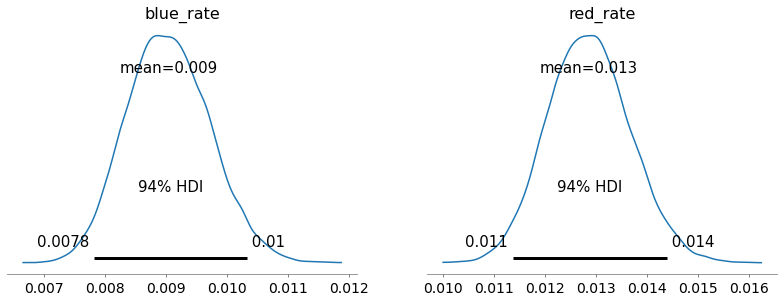

In [13]:
# Байесовская статистика
with pm.Model():
    blue_rate = pm.Beta('blue_rate', 1, 1)
    red_rate = pm.Beta('red_rate', 1, 1)

    blue_obs = pm.Bernoulli('blue_obs', blue_rate, observed=blue_conversions)
    red_obs = pm.Bernoulli('red_obs', red_rate, observed=red_conversions)

    trace = pm.sample(return_inferencedata=True, draws=10000)

# Посмотрим на графики распределения средних конверсий
az.plot_posterior(trace)

# Найдем вероятность превосходства красного варианта над синим
blue_rate_samples = trace.posterior['blue_rate'].values
red_rate_samples = trace.posterior['red_rate'].values
print(f'Probability that red is better: {(red_rate_samples > blue_rate_samples).mean():.1%}.')

In [21]:
# Теперь применим наш способ подсчета вероятности превосходства через формулу и через сэмплирование
alphas = (blue_conversions.sum(), red_conversions.sum())
betas = (blue_conversions.shape[0] - blue_conversions.sum(),
         red_conversions.shape[0] - red_conversions.sum())
print(f"Вероятность, что тестовый вариант лучше по точной формуле: "
      f"{100 * np.round(calc_prob_between(alphas, betas), 3)}%")
print(f"Вероятность, что тестовый вариант лучше через сэмплирование: " 
      f"{100 * np.round(calc_prob_between_sampling(alphas, betas), 3)}%")

Вероятность, что тестовый вариант лучше по точной формуле: 100.0%
Вероятность, что тестовый вариант лучше через сэмплирование: 100.0%


## abyes package
Данный пакет помогает принимать решение о победителе в зависимости
от разных критериев

In [22]:
exp = ab.AbExp(method='analytic', decision_var = 'es',
               rule='loss', toc=(0.01), alpha=0.95, plot=True)
exp.experiment(data.T)

NameError: name 'ab' is not defined

In [ ]:
data = np.random.binomial([1, 1], [0.3, 0.31], size=(20000, 2))
import abyes as ab
exp = ab.AbExp(method='analytic', decision_var = 'es',
               rule='rope', rope=(-0.04,0.04), alpha=0.95, plot=True)
exp.experiment(data.T)
print(f"prob super = {calc_prob_between(data.sum(axis=0), data.shape[0] - data.sum(axis=0))}")

In [ ]:
exp = ab.AbExp(method='analytic', decision_var = 'es',
               rule='loss', toc=0.01, plot=True)
exp.experiment(data.T)

In [ ]:
exp = ab.AbExp(method='mcmc', decision_var = 'es',
               rule='rope', alpha=0.95, plot=True)
exp.experiment(data.T)

In [ ]:
exp = ab.AbExp(method='compare', decision_var = 'es', plot=True)
exp.experiment(data.T)

## PyMC3

In [ ]:
alphas, betas = [334, 338], [1385 - 334, 1385 - 338]
print(calculate_bayesian_probability(2, 10000, 17, alphas, betas))
print(calc_prob_between(alphas, betas))


# PyMC3

np.random.seed(123)
n_experiments = 1000
theta_real = 0.35
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)

with pm.Model() as our_first_model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    y = pm.Bernoulli('y', p=theta, observed=data)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start, chains=15, cores=4)


burnin = 100
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta': theta_real})
pm.plot_posterior(chain)



mu1 = 82
mu2 = 78
var1 = mu1 * (1 - 0.307)
var2 = mu2 * (1 - 0.274)

cohens = (mu1 - mu2) / np.sqrt((var1 + var2) / 2)
stats.beta.cdf(x=cohens/np.sqrt(2), a=(82 + 78) / 2, b=(267 + 284)/2)
stats.norm.cdf(x=cohens/np.sqrt(2))


tips = sns.load_dataset('tips')
y = tips['tip'].values
idx = pd.Categorical(tips['day']).codes
x = set(tips['day'])

with pm.Model() as comparing_groups:
    means = pm.Normal('means', mu=0, sd=10, shape=len(set(x)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(x)))
    y = pm.Normal('y', mu=means[idx], sd=sds[idx], observed=y)
    trace_cg = pm.sample(5000, chains=15, cores=15)
chain_cg = trace_cg[100::]
pm.plot_trace(chain_cg)

pm.sample_ppc()

summar = az.summary(trace_cg)

ppc = pm.sample_posterior_predictive(trace_cg, samples=1000,
                                     model=comparing_groups)

az.ppc

In [ ]:
from dataclasses import dataclass
from typing import Dict, List, Union

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import pymc3.math as pmm

from scipy.stats import bernoulli, expon

print(f"Running on PyMC3 v{pm.__version__}")

@dataclass
class BetaPrior:
    alpha: float
    beta: float
@dataclass
class BinomialData:
    trials: int
    successes: int

RANDOM_SEED = 4000
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

class ConversionModelTwoVariant:
    def __init__(self, priors: BetaPrior):
        self.priors = priors

    def create_model(self, data: List[BinomialData]) -> pm.Model:
        trials = [d.trials for d in data]
        successes = [d.successes for d in data]
        with pm.Model() as model:
            p = pm.Beta("p", alpha=self.priors.alpha, beta=self.priors.beta, shape=2)
            obs = pm.Binomial("y", n=trials, p=p, shape=2, observed=successes)
            reluplift = pm.Deterministic("reluplift_b", p[1] / p[0] - 1)
        return model

In [ ]:
our_prior = ConversionModelTwoVariant(BetaPrior(alpha=2, beta=2))
weak_prior = ConversionModelTwoVariant(BetaPrior(alpha=100, beta=100))
strong_prior = ConversionModelTwoVariant(BetaPrior(alpha=10000, beta=10000))

with our_prior.create_model(data=[BinomialData(1, 1), BinomialData(1, 1)]):
    our_prior_predictive = pm.sample_prior_predictive(samples=10000)
with weak_prior.create_model(data=[BinomialData(1, 1), BinomialData(1, 1)]):
    weak_prior_predictive = pm.sample_prior_predictive(samples=10000)
with strong_prior.create_model(data=[BinomialData(1, 1), BinomialData(1, 1)]):
    strong_prior_predictive = pm.sample_prior_predictive(samples=10000)

In [ ]:
our_prior_predictive

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(7, 7), sharex=True)

# az.plot_posterior(our_prior_predictive["reluplift_b"], textsize=10, ax=axs[0], kind="hist")
# axs[0].set_title(f"B vs. A Rel Uplift Prior Predictive, {our_prior.priors}", fontsize=10)
# axs[0].axvline(x=0, color="red")

az.plot_posterior(weak_prior_predictive["reluplift_b"], textsize=10, ax=axs[1], kind="hist")
axs[1].set_title(f"B vs. A Rel Uplift Prior Predictive, {weak_prior.priors}", fontsize=10)
axs[1].axvline(x=0, color="red")

az.plot_posterior(strong_prior_predictive["reluplift_b"], textsize=10, ax=axs[2], kind="hist")
axs[2].set_title(f"B vs. A Rel Uplift Prior Predictive, {strong_prior.priors}", fontsize=10)
axs[2].axvline(x=0, color="red")

In [ ]:
def generate_binomial_data(
    variants: List[str], true_rates: List[str], samples_per_variant: int = 100000
) -> pd.DataFrame:
    data = {}
    for variant, p in zip(variants, true_rates):
        data[variant] = bernoulli.rvs(p, size=samples_per_variant)
    agg = (
        pd.DataFrame(data)
        .aggregate(["count", "sum"])
        .rename(index={"count": "trials", "sum": "successes"})
    )
    return agg
# Example generated data
generate_binomial_data(["A", "B"], [0.23, 0.23])

In [ ]:
def run_scenario_twovariant(
    variants: List[str],
    true_rates: List[float],
    samples_per_variant: int,
    our_prior: BetaPrior,
    weak_prior: BetaPrior,
    strong_prior: BetaPrior,
) -> None:
    generated = generate_binomial_data(variants, true_rates, samples_per_variant)
    data = [BinomialData(**generated[v].to_dict()) for v in variants]
    with ConversionModelTwoVariant(priors=weak_prior).create_model(data):
        trace_weak = pm.sample(draws=5000, return_inferencedata=True, cores=1, chains=2)
    with ConversionModelTwoVariant(priors=strong_prior).create_model(data):
        trace_strong = pm.sample(draws=5000, return_inferencedata=True, cores=1, chains=2)

    true_rel_uplift = true_rates[1] / true_rates[0] - 1

    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    az.plot_posterior(trace_weak.posterior["reluplift_b"], textsize=10, ax=axs[0], kind="hist")
    axs[0].set_title(f"True Rel Uplift = {true_rel_uplift:.1%}, {weak_prior}", fontsize=10)
    axs[0].axvline(x=0, color="red")
    az.plot_posterior(trace_strong.posterior["reluplift_b"], textsize=10, ax=axs[1], kind="hist")
    axs[1].set_title(f"True Rel Uplift = {true_rel_uplift:.1%}, {strong_prior}", fontsize=10)
    axs[1].axvline(x=0, color="red")
    fig.suptitle("B vs. A Rel Uplift")
    return data

In [ ]:
run_scenario_twovariant(
    variants=["A", "B"],
    true_rates=[0.23, 0.23],
    samples_per_variant=1000,
    our_prior=BetaPrior(alpha=1, beta=1),
    weak_prior=BetaPrior(alpha=100, beta=100),
    strong_prior=BetaPrior(alpha=10000, beta=10000),
)

In [ ]:
get_size_zratio(21, 0.5, alpha=0.05, beta=0.8)

In [ ]:
data = run_scenario_twovariant(
    variants=["A", "B"],
    true_rates=[0.21, 0.211],
    samples_per_variant=10000,
    our_prior=BetaPrior(alpha=1, beta=1),
    weak_prior=BetaPrior(alpha=100, beta=100),
    strong_prior=BetaPrior(alpha=10000, beta=10000),
)

In [ ]:
calc_prob_between([data[0].successes, data[1].successes], 
                  [data[0].trials - data[0].successes, 
                   data[1].trials - data[1].successes])